# Implementación de Modelos de Espacio de Estados para Analizar el Impacto del COVID-19 en Precios Inmobiliarios en CDMX

### Introducción
El análisis de la dinámica de precios inmobiliarios ante shocks como la pandemia de COVID-19 requiere herramientas estadísticas robustas que permitan identificar efectos causales y modelar la evolución temporal y espacial de los precios. Los modelos de espacio de estados (State Space Models, SSM) son especialmente útiles para este tipo de análisis, ya que permiten modelar series de tiempo con componentes latentes y pueden incorporar heterogeneidad espacial, por ejemplo, a nivel de hexágono o colonia.

3. Estructura del Modelo de Espacio de Estados
El modelo clásico de espacio de estados para series de tiempo univariadas es:

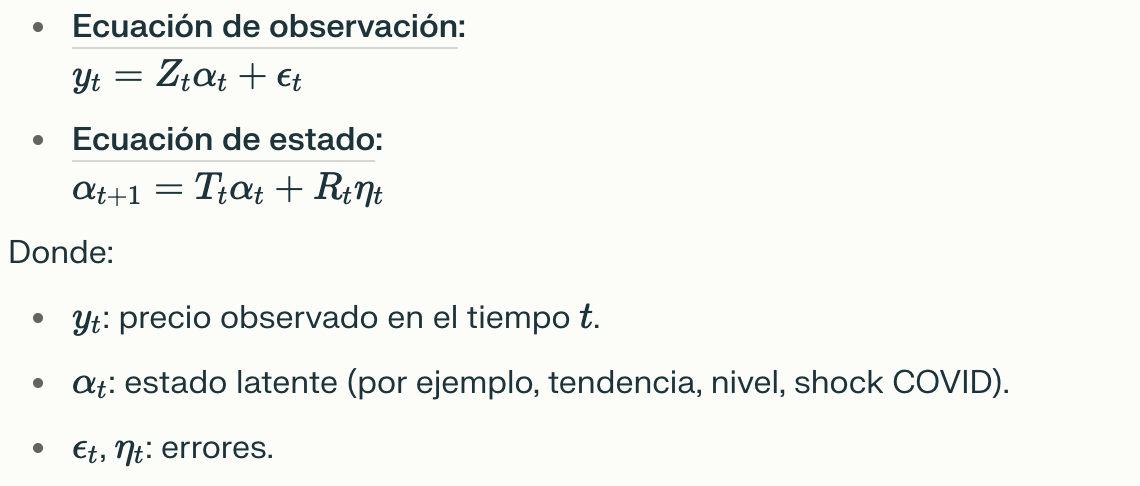

Puedes especificar modelos locales de nivel, tendencia, o modelos más complejos como local linear trend, y añadir variables exógenas (por ejemplo, un indicador de COVID-19).

4. Implementación en Python con statsmodels
A continuación, un ejemplo para modelar la serie de tiempo de precios para cada hexágono o colonia usando un modelo local linear trend e incluyendo un dummy de intervención por COVID-19:

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.structural import UnobservedComponents
import matplotlib.pyplot as plt

def fit_ssm_per_hex(df, hex_col='hex_id', date_col='fecha', price_col='precio_m2', covid_col='covid_dummy'):
    results_dict = {}
    for hex_id, group in df.groupby(hex_col):
        group = group.sort_values(date_col)
        y = group[price_col].values
        exog = group[[covid_col]].values
        model = UnobservedComponents(
            endog=y,
            level='local level',
            trend=True,
            exog=exog
        )
        res = model.fit(disp=False)
        results_dict[hex_id] = res
    return results_dict

# --- Cargar datos y preparar columnas básicas ---
file_path = '../data/properties_predicted.parquet'
df = pd.read_parquet(file_path)

# Asegura formato de fecha y renombra si es necesario
if 'valuation_date' in df.columns:
    df = df.rename(columns={'valuation_date': 'fecha'})
df['fecha'] = pd.to_datetime(df['fecha'])

# Asegúrate de que las columnas requeridas existen
required_cols = ['hex_id', 'fecha', 'precio_m2', 'covid_dummy']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Falta la columna requerida: {col}")

df = df.sort_values(['hex_id', 'fecha'])

# Ajuste del modelo por hexágono
results = fit_ssm_per_hex(df)

# Visualización para un hexágono específico
hex_id = list(results.keys())[0]
res = results[hex_id]

# Acceso correcto al nivel latente
if hasattr(res, 'level'):
    plt.plot(res.level.smoothed, label='Nivel latente')
else:
    plt.plot(res.filtered_state[0], label='Nivel latente (filtered_state)')
plt.plot(res.model.endog, label='Precio observado')
plt.legend()
plt.title(f'Hexágono {hex_id}')
plt.show()

# Efecto estimado de COVID-19
covid_param = [p for p in res.params.index if 'covid' in p]
if covid_param:
    print('Coeficiente COVID:', res.params[covid_param[0]])
else:
    print('No se encontró el coeficiente de COVID-19.')


ValueError: Falta la columna requerida: precio_m2

In [2]:
print(df.columns)

Index(['observation_id', 'y', 'y_pred', 'y_fitted', 'y_pred_fitted', 'set',
       'half_bathrooms', 'full_bathrooms',
       'property_class_more_common_in_area', 'neighborhood',
       ...
       'hex_embedding_9_d16_v2', 'hex_embedding_10_d16_v2',
       'hex_embedding_11_d16_v2', 'hex_embedding_12_d16_v2',
       'hex_embedding_13_d16_v2', 'hex_embedding_14_d16_v2',
       'hex_embedding_15_d16_v2', 'hex_embedding_16_d16_v2', 'longitude',
       'latitude'],
      dtype='object', length=133)
